In [ ]:
!nvidia-smi

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import csv
import time
import os

In [3]:
import cv2 as cv
from motrackers.detectors import YOLOv3
from motrackers import CentroidTracker, CentroidKF_Tracker, SORT, IOUTracker
#from motrackers.utils import draw_tracks
import ipywidgets as widgets

In [4]:
VIDEO_FILE = "test.mp4"
WEIGHTS_PATH = './examples/pretrained_models/yolo_weights/yolov4.weights'
CONFIG_FILE_PATH = './examples/pretrained_models/yolo_weights/yolov4.cfg'
LABELS_PATH = "./examples/pretrained_models/yolo_weights/coco_names.json"
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5

MAX_SEQ_LENGTH = 2000
NUM_FEATURES = 2048
CONFIDENCE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.2
DRAW_BOUNDING_BOXES = True
USE_GPU = True

In [5]:
tracker = CentroidKF_Tracker(max_lost=0, tracker_output_format='mot_challenge')

In [6]:
model = YOLOv3(
    weights_path=WEIGHTS_PATH,
    configfile_path=CONFIG_FILE_PATH,
    labels_path=LABELS_PATH,
    confidence_threshold=CONFIDENCE_THRESHOLD,
    nms_threshold=NMS_THRESHOLD,
    draw_bboxes=DRAW_BOUNDING_BOXES,
    use_gpu=USE_GPU
)

In [7]:
def autocrop(image, threshold=0):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

In [ ]:
def main(video_path, model, tracker):
    frames = []
    cap = cv.VideoCapture(video_path)
    colorTracker = {}
    trk_dict={}
    count = 0
    prev_frame_time = 0
    new_frame_time = 0
    try:
        while True:
            ok, image = cap.read()

            if not ok:
                print("Cannot read the video feed.")
                break
            
            image = cv.resize(image, (700, 500))
            booli, output = model.detect(image)
            #print('below detect')
            if(booli != False):
                bboxes, confidences, class_ids = output
                tracks = tracker.update(bboxes, confidences, class_ids)
                #print(class_ids)
                #print('below tracking')
                image, colorTracker = model.draw_bboxes(image.copy(), bboxes, confidences, class_ids, tracks, colorTracker)
                #print('below drawing')
                
                #frame = crop_center_square(updated_image)
#             gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
#             _,thresh = cv.threshold(gray,1,255,cv.THRESH_BINARY)
#             contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
#             cnt = contours[0]
#             x,y,w,h = cv.boundingRect(cnt)
#             frame = image[y:y+h,x:x+w]
            #print(image.shape)
            image = autocrop(image)
            frame = cv.resize(image, (224, 224))
            frame = frame[:, :, [2, 1, 0]]
            frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
            #print('below resize')
           # frame = frame[20:210, 10:210]
            frames.append(frame)
            #print('below append')
            count += 1
            #print(count)
            #print(type(frames))
            #print(f'{count}-{fps}')
            cv.imshow("image", frame)
            #print('below show')
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        cap.release()
        cv.destroyAllWindows()
    return np.array(frames)
main('test/test.mp4', model, tracker)

In [ ]:
# def create_dir(path):
#     try:
#         os.stat(path)
#     except:
#         os.mkdir(path)  

In [ ]:
# def initialize_dirs():
#     create_dir('E:/dataset/')
#     create_dir('E:/dataset/Train/')
#     create_dir('E:/dataset/Test')
#     create_dir('E:/dataset/Train/Anomaly/')
#     create_dir('E:/dataset/Test/Anomaly/')
#     create_dir('E:/dataset/Train/Normal/')
#     create_dir('E:/dataset/Test/Normal/')
# initialize_dirs()

In [ ]:
def get_size(start_path = 'data/'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

In [ ]:
trainAno = pd.read_csv("AnomalyTrain.csv")
for i in trainAno.index:
    if trainAno.at[i, 'progress'] == -1:
        vid = trainAno.at[i, 'path']
        print(vid)
        frames = main(vid, model, tracker)
        count = 0
        for j in frames:
            cv.imwrite('E:/dataset/Train/Anomaly/' + vid.split('\\')[-1].split('.')[0]+f'_frame{count}.jpg', j)
            count+=1
        trainAno.at[i, 'progress'] = 1
        trainAno.at[i, 'count'] = count
        trainAno.to_csv('AnomalyTrain.csv', index = True)

In [ ]:
testAno = pd.read_csv("AnomalyTest.csv")
for i in testAno.index:
    if testAno.at[i, 'progress'] == -1:
        vid = testAno.at[i, 'path']
        print(vid)
        frames = main(vid, model, tracker)
        count = 0
        for j in frames:
            cv.imwrite('E:/dataset/Test/Anomaly/' + vid.split('\\')[-1].split('.')[0]+f'_frame{count}.jpg', j)
            count+=1
        testAno.at[i, 'progress'] = 1
        testAno.at[i, 'count'] = count
        testAno.to_csv('AnomalyTest.csv', index = True)

In [ ]:
testNor = pd.read_csv("NormalTrain.csv")
for i in testNor.index:
    if testNor.at[i, 'progress'] == -1:
        vid = testNor.at[i, 'path']
        print(vid)
        frames = main(vid, model, tracker)
        count = 0
        for j in frames:
            cv.imwrite('E:/dataset/Test/Normal/' + vid.split('\\')[-1].split('.')[0]+f'_frame{count}.jpg', j)
            count+=1
        testNor.at[i, 'progress'] = 1
        testNor.at[i, 'count'] = count
        testNor.to_csv('NormalTrain.csv', index = True) 

In [ ]:
trainNor = pd.read_csv("NormalTest.csv")
print(trainNor.index)
for i in trainNor.index:
    if trainNor.at[i, 'progress'] == -1:
        vid = trainNor.at[i, 'path']
        print(vid)
        frames = main(vid, model, tracker)
        count = 0
        for j in frames:
            cv.imwrite('E:/dataset/Train/Normal/' + vid.split('\\')[-1].split('.')[0]+f'_frame{count}.jpg', j)
            count+=1
        trainNor.at[i, 'progress'] = 1
        trainNor.at[i, 'count'] = count
        trainNor.to_csv('NormalTest.csv', index = True) 

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import cv2 as cv
# frames = []
# colorTracker = {}
# image = cv.imread("street2.jpg")
# image = cv.resize(image, (700, 500))
# booli, output = model.detect(image)
# if(booli == False):
#     frame = cv.resize(output, (224, 224))
#     #print(f'false:{count}')
# else:
#     bboxes, confidences, class_ids = output
#     tracks = tracker.update(bboxes, confidences, class_ids)
#     #print(class_ids)
# #             print(len(tracks))
#     frame, colorTracker = model.draw_bboxes(image.copy(), bboxes, confidences, class_ids, tracks, colorTracker)
#     frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
#     fig = plt.figure(figsize=(12,7))
#     plt.imshow(frame)
# # frame = frame[20:210, 10:210]
# #print(count)
# #print(type(frames))
# #print(f'{count}-{fps}')


In [ ]:
# fig.savefig('obj2.jpg', bbox_inches='tight', dpi=150)

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()) # list of DeviceAttributes

In [ ]:
SIZE = (224,224)
NEGATIVES_PATH_TRAIN = 'E:/dataset/Train/Normal/'
POSITIVES_PATH_TRAIN = 'E:/dataset/Train/Anomaly/'
POSITIVES_PATH_VALID = 'E:/dataset/Test/Normal/'
NEGATIVES_PATH_VALID = 'E:/dataset/Test/Anomaly/'

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_conv.summary()
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(vgg_conv, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
def build_feature_extractor():
    model = models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(2, activation='softmax'))
    return model

build_feature_extractor().summary()
tf.keras.utils.plot_model(build_feature_extractor(), to_file='model2.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
%%time
train_batchsize = 16
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory('E:/dataset/Train/', class_mode='categorical', batch_size=train_batchsize, target_size = SIZE)

In [ ]:
%%time
val_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
val_generator = val_datagen.flow_from_directory('E:/dataset/Test/', class_mode='categorical', batch_size=train_batchsize, target_size = SIZE)

In [ ]:
# E:\Dataset\Test\Anomaly
# 348048
# E:\Dataset\Test\Normal
# 137266
# E:\Dataset\Train\Anomaly
# 1223394
# E:\Dataset\Train\Normal
# 1151560



# E:\Dataset\Test\Anomaly
# 275687
# E:\Dataset\Test\Normal
# 137266
# E:\Dataset\Train\Anomaly
# 958196
# E:\Dataset\Train\Normal
# 1151560

In [ ]:
import pandas as pd

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
##https://www.tensorflow.org/tensorboard/get_started



model = build_feature_extractor()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
filepath="weights/Feature_Extractor2.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]
# Train the model
print('Now fitting')
history = model.fit(
              train_generator,
              steps_per_epoch=train_generator.samples/64,
              validation_data = val_generator,
              validation_steps = val_generator.samples/64,
              epochs=100,
              callbacks=callbacks_list)
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()
# Save the trained model to disk
model.save('weights/Feature_Extractor2.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('weights/Feature_Extractor.h5')

In [ ]:
from tensorflow.keras.models import Model
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers

inp = model.input
out = model.layers[-4].output
feat_extractor = Model(inputs = [inp], outputs = [out])
feat_extractor.summary()

feat_extractor.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
import re
import numpy as np
import os
import cv2
from tqdm import tqdm
import pandas as pd

LOOK_BACK = 4

def seperate(POSITIVES_PATH):
    data = np.array([])
    numbers = []
    # POSITIVE LABELS
    for value in os.listdir(POSITIVES_PATH):
#         print(value.split('_'))
        
        numbers.append(value.split('_')[1])
#         print(numbers)
    numbers=np.unique(numbers)
    df = pd.DataFrame({'number':numbers, 'npDataFile':["-1"]*len(numbers)})
    return df
    
    
    # filter by video
def create_prediction(POSITIVES_PATH, numb, ind):
    frames = []
    data = np.array([])
    # append image name

    for value in os.listdir(POSITIVES_PATH):
        if value.split('_')[1] == numb:
            frames.append(value)

    # sort image frame by frame number
    
    frames = sorted(frames, key = lambda x: int(re.findall(r'\d+', x.split('_')[-1].split('.')[0])[0]))
    print(len(frames))
    print(f'{ind} : {numb}')
    image_data = np.zeros((len(frames), 256))
        
    for index, image in tqdm(enumerate(frames)):
        img = cv2.imread(POSITIVES_PATH + image)
        vect = feat_extractor.predict(img.reshape(1,224,224,3))
        image_data[index,:] = vect

    # for each frame get tensor with lookbacks
    stacked_data = np.zeros((len(frames), look_back, 256))
    for index in range(len(frames)):
        stacked_data[index, 0, :] = image_data[index]
        for lb in range(1, look_back):
            if index - lb >= 0:
                stacked_data[index, lb, :] = image_data[index - lb]
            else:
                stacked_data[index, lb, :] = np.zeros(256)

    if data.shape[0] == 0:
        return stacked_data
    else:
        return np.concatenate([data, stacked_data], axis = 0)


    
    
    

#     for value in os.listdir(NEGATIVES_PATH):
#         numbers.append(int(re.findall(r'\d+', value.split('_')[2])[0]))

#     # filter by video
#     for numb in np.unique(numbers):
#         frames = []
#         # append image name
#         for value in os.listdir(NEGATIVES_PATH):
#             if int(re.findall(r'\d+', value.split('_')[2])[0]) == numb:
#                 frames.append(value)
#         # sort image frame by frame number
#         frames = sorted(frames, key = lambda x: int(re.findall(r'\d+', x.split('_')[-1].split('.')[0])[0]))
#         image_data = np.zeros((len(frames), 1024))

#         # get feature vector from vgg16 for each frame and stack
#         for index, image in tqdm(enumerate(frames)):
#             img = cv2.imread(NEGATIVES_PATH + image)
#             vect = feat_extractor.predict(img.reshape(1,224,224,3))
#             image_data[index,:] = vect

#         # for each frame get tensor with lookbacks
#         stacked_data = np.zeros((len(frames), look_back, 256))
#         for index in tqdm(range(len(frames))):
#             labels = np.append(labels, [0])
#             stacked_data[index, 0, :] = image_data[index]
#             for lb in range(1, look_back):
#                 if index - lb >= 0:
#                     stacked_data[index, lb, :] = image_data[index - lb]
#                 else:
#                     stacked_data[index, lb, :] = np.zeros(256)

#         if data.shape[0] == 0:
#             data = stacked_data
#         else:
#             data = np.concatenate([data, stacked_data], axis = 0)

#     # one hot labels
#     from keras.utils import to_categorical
#     labels = to_categorical(labels)
#     return data, labels



In [ ]:
tr_data, tr_labels = data_to_lstm_format(POSITIVES_PATH_TRAIN, NEGATIVES_PATH_TRAIN, look_back=LOOK_BACK)

In [ ]:
# TestNormaldf = seperate(POSITIVES_PATH_VALID)
TestNormaldf = pd.read_csv('TestNormaldf.csv')
TestNormaldf

In [ ]:
# trainAno = pd.read_csv("AnomalyTrain.csv")
look_back = LOOK_BACK
for i in TestNormaldf.index:
    if TestNormaldf.at[i, 'npDataFile'] == "-1":
        nparray = create_prediction(POSITIVES_PATH_VALID, TestNormaldf.at[i, 'number'], i)
        filename = 'NPfiles/Test/Normal/'+str(TestNormaldf.at[i, 'number'])
        np.save(filename, nparray)
        TestNormaldf.at[i,'npDataFile'] = filename

In [ ]:
# TestNormaldf.to_csv('TestNormaldf.csv', index = False)

In [ ]:
# TestAnomalydf = seperate(NEGATIVES_PATH_VALID)
TestAnomalydf = pd.read_csv('TestAnomalydf.csv')
TestAnomalydf

In [ ]:
look_back = LOOK_BACK
for i in TestAnomalydf.index:
    if TestAnomalydf.at[i, 'npDataFile'] == "-1":
        print(TestAnomalydf.at[i, 'number'])
        nparray = create_prediction(NEGATIVES_PATH_VALID, TestAnomalydf.at[i, 'number'])
        filename = 'NPfiles/Test/Anomaly/'+str(TestAnomalydf.at[i, 'number'])
        np.save(filename, nparray)
        TestAnomalydf.at[i,'npDataFile'] = filename

In [ ]:
TestAnomalydf.to_csv('TestAnomalydf.csv', index = False)

In [ ]:
#TrainNormaldf = seperate(POSITIVES_PATH_TRAIN)
import pandas as pd
TrainNormaldf = pd.read_csv('TrainNormaldf.csv')
TrainNormaldf

In [ ]:
look_back = LOOK_BACK
count = 0
for i in TrainNormaldf.index:
    if TrainNormaldf.at[i, 'npDataFile'] != "-1":
        count += 1
#         nparray = create_prediction(POSITIVES_PATH_TRAIN, TrainNormaldf.at[i, 'number'], i)
#         filename = 'NPfiles/Train/Anomaly/'+str(TrainNormaldf.at[i, 'number'])
#         np.save(filename, nparray)
#         TrainNormaldf.at[i,'npDataFile'] = filename
#         del nparray

In [ ]:
TrainNormaldf.to_csv('TrainNormaldf.csv', index = False)

In [ ]:
count

In [ ]:
# TrainNormaldf2 = seperate(NEGATIVES_PATH_TRAIN)
TrainNormaldf2 = pd.read_csv('TrainNormaldf2.csv')
TrainNormaldf2

In [ ]:
look_back = LOOK_BACK
for i in TrainNormaldf2.index:
    if TrainNormaldf2.at[i, 'npDataFile'] == "-1" and i>144:
        nparray = create_prediction(NEGATIVES_PATH_TRAIN, TrainNormaldf2.at[i, 'number'], i)
        filename = 'NPfiles/Train/Normal/'+str(TrainNormaldf2.at[i, 'number'])
        np.save(filename, nparray)
        TrainNormaldf2.at[i,'npDataFile'] = filename
        del nparray

In [ ]:
TrainNormaldf2.to_csv('TrainNormaldf2.csv', index = False)

In [ ]:
import numpy as np
import os
from tqdm import tqdm

In [ ]:
def prepare_for_lstm_test1(): 
    count = 0
    data = np.array([])
    for values in tqdm(os.listdir('NPfiles/Test/Anomaly/')):
        stacked_data = np.load(os.path.join('NPfiles/Test/Anomaly/', values))
        count += len(stacked_data)
        if data.shape[0] == 0:
            data = stacked_data
        else:
            data = np.concatenate([data, stacked_data], axis = 0)
    labels = np.ones(count)
    return data, labels
            
            
def prepare_for_lstm_test2():    
    count = 0
    data = np.array([])
    for values in tqdm(os.listdir('NPfiles/Test/Normal/')):
        stacked_data = np.load(os.path.join('NPfiles/Test/Normal/', values))
        count += len(stacked_data)
        if data.shape[0] == 0:
            data = stacked_data
        else:
            data = np.concatenate([data, stacked_data], axis = 0)
    labels = np.zeros(count)
    return data, labels
        

In [ ]:
val_data1, val_labels1 = prepare_for_lstm_test1()

In [ ]:
val_data2, val_labels2 = prepare_for_lstm_test2()

In [ ]:
val_data = np.concatenate([val_data1, val_data2], axis=0)
val_labels = np.concatenate([val_labels1, val_labels2], axis=0)

In [ ]:
np.save("val_data.npy", val_data)
np.save("val_labels.npy", val_labels)

In [ ]:
def prepare_for_lstm_train1(): 
    count = 0
    data = np.array([])
    for values in tqdm(os.listdir('NPfiles/Train/Anomaly/')):
        stacked_data = np.load(os.path.join('NPfiles/Train/Anomaly/', values))
        count += len(stacked_data)
        if data.shape[0] == 0:
            data = stacked_data
        else:
            data = np.concatenate([data, stacked_data], axis = 0)
    labels = np.ones(count)
    return data, labels
            
            
def prepare_for_lstm_train2():    
    count = 0
    data = np.array([])
    for values in tqdm(os.listdir('NPfiles/Train/Normal/')):
        stacked_data = np.load(os.path.join('NPfiles/Train/Normal/', values))
        count += len(stacked_data)
        if data.shape[0] == 0:
            data = stacked_data
        else:
            data = np.concatenate([data, stacked_data], axis = 0)
    labels = np.zeros(count)
    return data, labels
        

In [ ]:
train_data1, train_labels1 = prepare_for_lstm_train1()

In [ ]:
train_data2, train_labels2 = prepare_for_lstm_train2()

In [ ]:
train_data = np.concatenate([train_data1, train_data2], axis=0)
train_labels = np.concatenate([train_labels1, train_labels2], axis=0)

In [ ]:
np.save("train_data.npy", train_data)
np.save("train_labels.npy", train_labels)

In [12]:
import numpy as np
# val_data = np.load('val_data.npy')
# val_labels = np.load('val_labels.npy')
# train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

In [5]:
from tensorflow.keras.utils import to_categorical
val_labels = to_categorical(val_labels)
train_labels = to_categorical(train_labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
num_features = 256
# def build_model():
#     inp = L.Input(shape = (4, num_features))
#     model = Sequential()
#     model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(4, 256)))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(16, return_sequences=True)))
#     model.add(Dropout(0.2))
#     model.add(TimeDistributed(Dense(2, activation='softmax')))
#     model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])
#     return model

def build_model():
    inp = L.Input(shape = (4, num_features))
    
    """ Use CuDNNLSTM if your machine supports CUDA
        Training time is significantly faster compared to LSTM """
    
    #x = L.LSTM(64, return_sequences = True)(inp)tf.compat.v1.keras.layers.CuDNNLSTM
    x = tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences = True)(inp)
    x = L.Dropout(0.2)(x)
    #x = L.LSTM(16)(x)
    x = tf.compat.v1.keras.layers.CuDNNLSTM(16)(x)
    out = L.Dense(2, activation = 'softmax')(x)
    model = Model(inputs = [inp], outputs = [out])
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])
    return model

In [1]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir data/_training_logs_2/rnn/

In [ ]:
model = build_model()

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
##https://www.tensorflow.org/tensorboard/get_started
log_dir = "data/_training_logs_2/rnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history = model.fit(train_data, train_labels, 
                    validation_data = (val_data, val_labels),
                    callbacks = callbacks_list,
                    verbose = 1, epochs = 20, batch_size = 64)

In [ ]:
# model.save('weights/RNN_2.h5')

In [2]:
# make predictions
from tensorflow.keras.models import load_model
model = load_model('weights/RNN_2.h5')

trainPredict = model.predict(train_data)
testPredict = model.predict(val_data)

# invert predictions


In [15]:
# testPredict = np.argmax(testPredict,axis=1)
trainPredict = np.argmax(trainPredict,axis=1)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(testPredict, val_labels))
print(confusion_matrix(testPredict, val_labels))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78    147595
           1       0.80      0.85      0.82    172345

    accuracy                           0.80    319940
   macro avg       0.80      0.80      0.80    319940
weighted avg       0.80      0.80      0.80    319940

[[111124  36471]
 [ 26142 146203]]


In [18]:
from sklearn.metrics import accuracy_score, f1_score
MNB_f1 = round(f1_score(val_labels, testPredict, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(val_labels, testPredict)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

Accuracy :  80.43  %
f1_score :  0.805


In [20]:
import cv2
cap=cv2.VideoCapture("test/test.mp4")
try:
    while(True):

        ret1,frame1= cap.read()
        if not ret1:
                print("Cannot read the video feed.")
                break
        
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray1 = cv2.GaussianBlur(gray1, (21, 21), 0)
        ret2,frame2=cap.read()
        temp = cv2.resize(frame2, (350, 200))
        cv2.imshow('input',temp)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.GaussianBlur(gray2, (21, 21), 0)
        deltaframe=cv2.absdiff(gray1,gray2)
#         cv2.imshow('delta',deltaframe)
        threshold = cv2.threshold(deltaframe, 25, 255, cv2.THRESH_BINARY)[1]
        threshold = cv2.dilate(threshold,None)
        temp2 = cv2.resize(threshold, (350, 200))
        cv2.imshow('threshold',temp2)
        countour,heirarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for i in countour:
            if cv2.contourArea(i) < 50:
                continue

            (x, y, w, h) = cv2.boundingRect(i)
            cv2.rectangle(frame2, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv.putText(frame2, "Motion Detected", (10,25), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv.LINE_AA)
        temp3 = cv2.resize(frame2, (350, 200))
        cv2.imshow('window',temp3)

        if cv2.waitKey(20) == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
def manDown(video_path, model, tracker):
    frames = []
    cap = cv.VideoCapture(video_path)
    print(video_path)
    try:
        while True:
            ok, image = cap.read()

            if not ok:
                print("Cannot read the video feed.")
                break

            image = cv.resize(image, (700, 500))
            booli, output = model.detect(image)
            if(booli == False):
                cv.imshow("image", image)
                frames.append(image)
            else:
                centroid_dict = dict() 
                objectId = 0
                bboxes, confidences, class_ids = output
                tracks = tracker.update(bboxes, confidences, class_ids)
                
                for bb, conf, cid, trk in zip(bboxes, confidences, class_ids, tracks):
                    if (model.checkPerson):
                        xmin, ymin, xmax, ymax = model.convertBack(float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3]))
                        centroid_dict[objectId] = (int(bb[0]), int(bb[1]), xmin, ymin, xmax, ymax)
                
                    #print(tracks)
                    objId = tracks[0]
                    fall_alert_list = [] 
                    red_line_list = []
                    for id,p in centroid_dict.items():
                        dx, dy = p[4] - p[2], p[5] - p[3]  
                        difference = dy-dx
                        if difference < 0:
                            fall_alert_list.append(id)      

#                     for idx, box in centroid_dict.items():  # dict (1(key):red(value), 2 blue)  idx - key  box - value
#                         if idx in fall_alert_list:   # if id is in red zone list
#                             cv.rectangle(image, (box[2], box[3]), (box[4], box[5]), (255, 0, 0), 2) # Create Red bounding boxes  #starting point, ending point size of 2
#                         else:
#                             cv.rectangle(image, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2) 

                    if len(fall_alert_list)!=0:
                        text = "Fall Detected"



                    else:
                        text = "Fall Not Detected"
                        alert_var = 0           # makes sure that alert is generated when there are 20 simultaeous frames of fall detection

                    location = (10,25)
                    if len(fall_alert_list)!=0:
                        cv.putText(image, text, location, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv.LINE_AA)  # Display Text
                    else:
                        cv.putText(image, text, location, cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv.LINE_AA)  # Display Text

                    cv.imshow("image", image)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        cap.release()
        cv.destroyAllWindows()
    #return np.array(frames)

In [ ]:
manDown('test/fall.mp4', model, tracker)

In [9]:
import numpy as np
import cv2, re, os, warnings, time
from tensorflow.keras.models import Model
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
import tensorflow.keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

warnings.filterwarnings('ignore')
TAKE_FRAME = 1
LOOK_BACK = 4
VGG16_OUT = 256
SIZE = (224, 224)

FROM_WEBCAM = False
ALERT = False
Threshold = 0.60

positive_frames = 5
CAM_CONSTANT = 0

class FeatExtractor:
    def __init__(self, SIZE):
        self.size = SIZE
        self.vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(self.size[0], self.size[1], 3))
        for layer in self.vgg_conv.layers[:-4]:
            layer.trainable = False

        def build_feat_extractor():
            model = models.Sequential()
            model.add(self.vgg_conv)
            model.add(layers.Flatten())
            model.add(layers.Dense(256, activation='relu'))
            model.add(layers.Dropout(0.2))
            model.add(layers.Dense(128, activation = 'relu'))
            model.add(layers.Dense(2, activation='softmax'))
            return model

        self.model = build_feat_extractor()
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

        self.model.load_weights('weights/Feature_Extractor.h5')

        inp = self.model.input
        out = self.model.layers[-4].output
        self.model = Model(inputs=[inp], outputs=[out])

        self.model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

    def get_feats(self, frames):
        image_data = np.zeros((len(frames), VGG16_OUT))
        for index, image in enumerate(frames):
            vect = self.model.predict(image.reshape(1, self.size[0], self.size[1], 3))
            image_data[index, :] = vect

        image_data = image_data.reshape(1, len(frames), VGG16_OUT)
        return image_data

class RnnModel:

    def __init__(self, NUM_FEATURES, LOOK_BACK):
        self.num_features = NUM_FEATURES
        self.look_back = LOOK_BACK
        def build_model():
            inp = L.Input(shape=(self.look_back, self.num_features))
            x = L.LSTM(64, return_sequences=True)(inp)
            x = L.Dropout(0.2)(x)
            x = L.LSTM(16)(x)

            out = L.Dense(2, activation='softmax')(x)
            model = Model(inputs=[inp], outputs=[out])
            model.compile(loss='categorical_crossentropy',
                          optimizer=RMSprop(lr=1e-4),
                          metrics=['acc'])
            return model

        self.model = build_model()
        self.model.load_weights('weights/RNN_2.h5')

    def predict(self, frame_data):
        pred = self.model.predict(frame_data)
        return pred[0][1]

def __draw_label(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1
    color = (0, 0, 0)
    thickness = cv2.FILLED
    margin = 6

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 2, cv2.LINE_AA)


if __name__ == '__main__':
    prediction=[]
    cap = cv2.VideoCapture("test/test.mp4")
    colorTracker = {}
    cnt = 0
    frames = []
    fe = FeatExtractor(SIZE)
    rnn = RnnModel(VGG16_OUT, LOOK_BACK)
    total_frames = 0
    detect_certainty = []
    neg_certainty = []
    rval, frame = cap.read()
#     media_path = settings.MEDIA_ROOT
    # frame_size = (int(cap.get(3)), int(cap.get(4)))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     filename = f"test_processed_fall.webm"
    file_location = "processed_normal.mp4"
    out = cv2.VideoWriter(file_location, fourcc, 30, (700, 500))
    while (cap.isOpened()):
        cnt+=1
        ret, full = cap.read()
        if ret == True:
            image = cv2.resize(full, (700, 500))
            booli, output = model.detect(image)
            if(booli != False):
                bboxes, confidences, class_ids = output
                tracks = tracker.update(bboxes, confidences, class_ids)

                image, colorTracker = model.draw_bboxes(image.copy(), bboxes, confidences, class_ids, tracks, colorTracker)

            image = autocrop(image)
            frame = cv2.resize(image, (224, 224))
            frame = frame[:, :, [2, 1, 0]]
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frame = cv2.resize(frame, SIZE)
            if cnt % TAKE_FRAME == 0:
                frames.append(frame)
                pred = 0
                if len(frames) == LOOK_BACK:
                    feats = fe.get_feats(frames)
                    frames.pop(0)
                    initial = time.time()
                    pred = rnn.predict(feats)
                    final = time.time() - initial
    #                 print("")
    #                 print('[INFO] Frame acc. predictions:', pred)
    #                 print('Frame inference in %.4f seconds' % (final))
            if pred >= Threshold:
                __draw_label(image, 'Anomaly_Score: {:.2f}'.format(pred), (5, 30), (255, 255, 255))
#                     print("ANomaly")
                total_frames += 1
                detect_certainty.append(pred)
            else:
                neg_certainty.append(pred)
                if ALERT:
                    if total_frames > positive_frames:
                        neg = np.mean(neg_certainty)
                        pos = np.mean(detect_certainty)
                        time1 = total_frames * TAKE_FRAME / 30                          
                    detect_certainty = []
                    total_frames = 0
                __draw_label(image, 'Normal_Score: {:.2f}'.format(pred), (5, 30), (255, 255, 255))
           
            __draw_label(image, f"Frame: {cnt}", (400, 30), (255, 255, 255))
            cv2.imshow('Test_Window', image)
            out.write(image)
            prediction.append(pred)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

        else:
            break
    cap.release()
    cv.destroyAllWindows()

In [10]:
lenn = [x for x in range(0, len(prediction))]

In [15]:
len(lenn)

301

In [16]:
len(prediction)

301

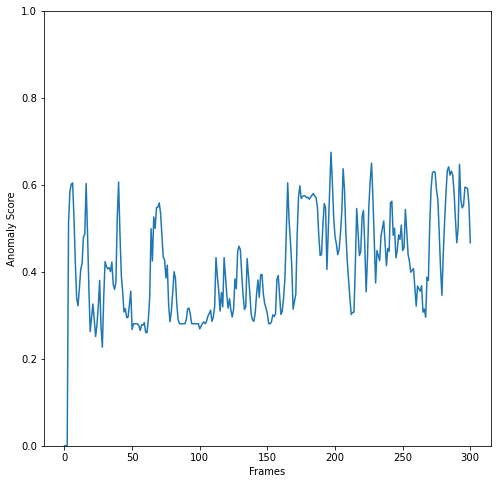

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(lenn, prediction)
# plt.title('Unemployment Rate Vs Year')
plt.xlabel('Frames')
plt.ylabel('Anomaly Score')
plt.ylim(0, 1)
plt.savefig('Anomaly_scores.png')
plt.show()